<br>
<h1 style = "font-size:60px; font-family:Monaco ; font-weight : normal; background-color: #000055 ; color : #9999ff; text-align: center; border-radius: 50px 50px;">SETI - Breakthrough Listen<br>EfficientNet B3</h1>
<br>

## Description of problem
The vast distances between stars/galaxies and the dramatic effects of the inverse square law make finding electromagnetic signals of intelligent civilizations a challenging task.  Breakthroughs in machine learning using computer vision and time series analysis are tools that may bring us closer to achieving this goal.  The purpose of this notebook, and the greater experiment that this notebook belongs to is to attempt to push the state of the art ever closer to realizing this goal.

## Seti Breakthrough-Listen Dataset
The purpose of this notebook is to use a pre-trained efficient-net model to classify cadence samples as negative or positive(anomolous signal).  The data consists of "cadence snippets taken from the Green Bank Telescope", which is a digital spectrometer that generates spectrograms using the Fourier Transform technique.  The data represent signal intensity as a function of frequency and time.  

The "Cadence" is described in the "Data Information" section of the competition:  
5 minutes on star “A”, then 5 minutes on star “B”, then back to star “A” for 5 minutes, then “C”, then back to “A”, then finishing with 5 minutes on star “D”. One set of six observations (ABACAD) is referred to as a “cadence”.  

The shape of the data is (6, 273, 256), where 273 represents the time (5 minutes) dimension, and 256 represents the frequency dimension.  


## This notebook originally created by: 
https://www.kaggle.com/anirudhg15/seti-et-baseline-efficientnetb3

In [61]:
# Imports
import os
import math
import numpy as np
import pandas as pd
from typing import List, Dict, Callable

# DL Modules
import tensorflow as tf
from tensorflow import keras
import efficientnet.tfkeras as efn

# ML / Data Prep
import sklearn
from sklearn import model_selection
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Test if GPU available
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
datadir: str = "/data/data/datasets/seti/"
train_labels: pd.DataFrame = pd.read_csv(os.path.join(datadir, "train_labels.csv"))

In [5]:
def id_to_path(sample_id: str) -> str:
    """ Return full path to numpy file from sample id """
    return os.path.join(datadir, "train", sample_id[0], f"{sample_id}.npy")

In [6]:
X = train_labels['id'].values
y = train_labels['target'].values

X_trainval, X_test, y_trainval, y_test = model_selection.train_test_split(
    X, 
    y, 
    test_size=.2, 
    random_state=42, 
    stratify=y
)

X_train, X_val, y_train, y_val = model_selection.train_test_split(
    X_trainval, 
    y_trainval, 
    test_size=.2, 
    random_state=42, 
    stratify=y_trainval
)

print(f"LENGTHS ; X_train : {len(X_train)}, X_val {X_val.shape}, X_test {X_test.shape}")
print(f"Number of positive samples ; y_train : {np.sum(y_train==1)}, y_val: {np.sum(y_val==1)}, y_test: {np.sum(y_test==1)}")
print(f"Ratio of positive samples ; y_train : {np.sum(y_train==1)/len(y_train):.3f}, y_val: {np.sum(y_val==1)/len(y_val):.3f}, y_test: {np.sum(y_test==1)/len(y_test):.3f}")

LENGTHS ; X_train : 38400, X_val (9600,), X_test (12000,)
Number of positive samples ; y_train : 3840, y_val: 960, y_test: 1200
Ratio of positive samples ; y_train : 0.100, y_val: 0.100, y_test: 0.100


In [7]:
X_train[:3]

array(['0add6ccf9b2e9ce', '1e4cb3f498e29ca', 'b6606b085a618f1'],
      dtype=object)

### Dataset class

In [8]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x_set, y_set=None, batch_size=32):
        self.x , self.y = x_set, y_set
        self.batch_size = batch_size
        self.is_train = False if y_set is None else True
        
    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)
    
    def __getitem__(self, idx):
        batch_ids = self.x[idx * self.batch_size: (idx + 1) * self.batch_size]
        if self.y is not None:
            batch_y = self.y[idx * self.batch_size: (idx + 1) * self.batch_size]
        
        list_x = [np.load(id_to_path(x))[::2] for x in batch_ids]
        batch_x = np.moveaxis(list_x,1,-1)
        batch_x = batch_x.astype("float") / 255
        
        if self.is_train:
            return batch_x, batch_y
        else:
            return batch_x

### Model Hyperparams

In [9]:
input_size = (273, 256, 3)
batch_size = 16
n_epoch = 2
seed = 42

### Model Definition

In [9]:
model = tf.keras.Sequential([
        efn.EfficientNetB3(input_shape=input_size,weights='imagenet',include_top=False),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(1, activation='sigmoid')
        ])

model.summary()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy', metrics=[keras.metrics.AUC()])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Model)      (None, 9, 8, 1536)        10783528  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1537      
Total params: 10,785,065
Trainable params: 10,697,769
Non-trainable params: 87,296
_________________________________________________________________


### Model Training

In [10]:
train = DataGenerator(X_train, y_train, batch_size=batch_size)
val = DataGenerator(X_val, y_val, batch_size=batch_size)
test = DataGenerator(X_test, batch_size=batch_size)

In [ ]:
model.fit(train, validation_data=val, epochs=n_epoch)

### Save model

In [11]:
model.save(os.path.join("models", "effnet_cadences_E2"))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/effnet_cadences_E2/assets


### Test model

In [12]:
preds_test = model.predict(test).flatten()

In [18]:
np.round(preds_test[:4]).astype(np.uint8)

array([0, 0, 0, 0], dtype=uint8)

In [16]:
y_test[:4]

array([0, 0, 0, 0])

In [19]:
acc = accuracy_score(y_test, np.round(preds_test).astype(np.int32))
acc

0.9190833333333334

### Continue training

In [20]:
model.fit(train, validation_data=val, epochs=n_epoch)

Epoch 1/2
2400/2400 [==============================] - 533s 222ms/step - loss: 0.2391 - auc: 0.7988 - val_loss: 0.2788 - val_auc: 0.7017
Epoch 2/2
2400/2400 [==============================] - 530s 221ms/step - loss: 0.1944 - auc: 0.8818 - val_loss: 0.3100 - val_auc: 0.6972


In [21]:
preds_test = model.predict(test).flatten()
acc = accuracy_score(y_test, np.round(preds_test).astype(np.int32))
acc

0.9205833333333333

In [22]:
model.save(os.path.join("models", "effnet_cadences_E4"))

INFO:tensorflow:Assets written to: models/effnet_cadences_E4/assets


In [23]:
for epoch in range(6, 21, 2):
    model.fit(train, validation_data=val, epochs=n_epoch)
    preds_test = model.predict(test).flatten()
    acc = accuracy_score(y_test, np.round(preds_test).astype(np.int32))
    print("TEST ACCURACY AFTER EPOCH {epoch} : {acc:.6f}")
    model.save(os.path.join("models", f"effnet_cadences_E{epoch}"))

Epoch 1/2
2400/2400 [==============================] - 529s 221ms/step - loss: 0.1382 - auc: 0.9461 - val_loss: 0.3693 - val_auc: 0.6844
Epoch 2/2
2400/2400 [==============================] - 530s 221ms/step - loss: 0.0862 - auc: 0.9818 - val_loss: 0.5456 - val_auc: 0.6706
TEST ACCURACY AFTER EPOCH {epoch} : {acc:.6f}
INFO:tensorflow:Assets written to: models/effnet_cadences_E6/assets
Epoch 1/2
2400/2400 [==============================] - 529s 221ms/step - loss: 0.0649 - auc: 0.9887 - val_loss: 0.6125 - val_auc: 0.6735
Epoch 2/2
2400/2400 [==============================] - 532s 222ms/step - loss: 0.0519 - auc: 0.9919 - val_loss: 0.6450 - val_auc: 0.6713
TEST ACCURACY AFTER EPOCH {epoch} : {acc:.6f}
INFO:tensorflow:Assets written to: models/effnet_cadences_E8/assets
Epoch 1/2
2400/2400 [==============================] - 528s 220ms/step - loss: 0.0450 - auc: 0.9931 - val_loss: 0.6862 - val_auc: 0.6599
Epoch 2/2
2400/2400 [==============================] - 517s 215ms/step - loss: 0.0396 -

### <font color='green'>^ forgot the 'f' in 'f-string'.  Whoops! ^</font>

# <font color='red'>BREAK:</font> Close webpage, reload model

In [10]:
model = keras.models.load_model(os.path.join("models", f"effnet_cadences_E20"))

In [11]:
preds_test = model.predict(test).flatten()
acc = accuracy_score(y_test, np.round(preds_test).astype(np.int32))
print(f"TEST ACCURACY AFTER EPOCH 20 : {acc:.6f}")

TEST ACCURACY AFTER EPOCH 20 : 0.905833


# Let's evaluate each of the saved models

In [11]:
preds: Dict[int, np.array] = {}
for epoch in range(2, 21, 2):
    model = keras.models.load_model(os.path.join("models", f"effnet_cadences_E{epoch}"))
    preds[epoch] = model.predict(test).flatten()
    acc = accuracy_score(y_test, np.round(preds[epoch]).astype(np.int32))
    f1 = f1_score(y_test, np.round(preds[epoch]).astype(np.int32))
    pos_preds = np.sum(np.round(preds[epoch]).astype(np.int32))
    print(f"TEST ACCURACY AFTER EPOCH {epoch} : {acc:.6f}; F1 : {f1:.6f}, Positive Preds : {pos_preds}")

TEST ACCURACY AFTER EPOCH 2 : 0.919083; F1 : 0.334476, Positive Preds : 259
TEST ACCURACY AFTER EPOCH 4 : 0.920583; F1 : 0.394921, Positive Preds : 375
TEST ACCURACY AFTER EPOCH 6 : 0.908167; F1 : 0.371005, Positive Preds : 552
TEST ACCURACY AFTER EPOCH 8 : 0.906833; F1 : 0.346963, Positive Preds : 512
TEST ACCURACY AFTER EPOCH 10 : 0.899583; F1 : 0.365456, Positive Preds : 699
TEST ACCURACY AFTER EPOCH 12 : 0.896417; F1 : 0.362237, Positive Preds : 749
TEST ACCURACY AFTER EPOCH 14 : 0.898167; F1 : 0.365524, Positive Preds : 726
TEST ACCURACY AFTER EPOCH 16 : 0.896500; F1 : 0.383929, Positive Preds : 816
TEST ACCURACY AFTER EPOCH 18 : 0.906083; F1 : 0.383142, Positive Preds : 627
TEST ACCURACY AFTER EPOCH 20 : 0.905833; F1 : 0.369420, Positive Preds : 592


# <font color='red'>Not predicting enough positives!</font>

In [13]:
print(f"Epoch 16's 816 of {len(y_test)} is only a ratio of {816/len(y_test):.3f}; need ratio of 0.1")

Epoch 16's 816 of 12000 is only a ratio of 0.068; need ratio of 0.1


# Let's look at TP, FP, TN, FN for E4

In [19]:
preds4 = np.round(preds[4]).astype(np.int32)

In [22]:
np.sum(preds4)

375

In [26]:
np.sum(y_test)

1200

In [27]:
np.sum((preds4==1)&(y_test==1))

311

In [28]:
TP: int = np.sum((preds4==1)&(y_test==1))
TP

311

In [29]:
FP: int = np.sum(preds4) - TP
FP

64

In [30]:
TN: int = np.sum((preds4==0)&(y_test==0))
TN

10736

In [33]:
FN: int = (len(y_test) - np.sum(preds4)) - TN
FN

889

In [37]:
cm = sklearn.metrics.confusion_matrix(y_test, preds4)

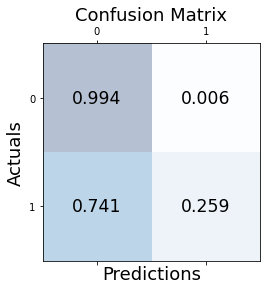

In [52]:
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(4,4))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [44]:
np.round(cm, 3)

array([[0.994, 0.006],
       [0.741, 0.259]])

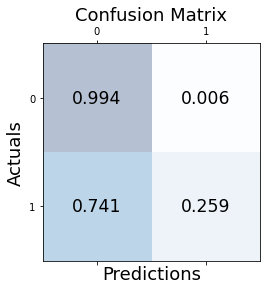

In [51]:
cm = np.round(sklearn.metrics.confusion_matrix(y_test, preds4, normalize="true"), 3)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(4,4))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [63]:
acc = accuracy_score(y_test, preds4)
f1 = f1_score(y_test, preds4)
auc = roc_auc_score(y_test, preds4)
pos_preds = np.sum(all_preds.max(axis=0))
print(f"TEST ACCURACY FOR EPOCH 4 : {acc:.6f}; F1 : {f1:.6f}, ROC AUC {auc:.6f}, Positive Preds : {pos_preds}")

TEST ACCURACY FOR EPOCH 4 : 0.920583; F1 : 0.394921, ROC AUC 0.626620, Positive Preds : 1889


# While most Positive Predictions are TP, we miss most of them
High PPV, but low recall/sensitivity
- sensitivity, recall, hit rate, or true positive rate (TPR) : TP / P
- specificity, selectivity or true negative rate (TNR) : TN / N
- precision or positive predictive value (PPV) : TP / (TP + FP)
- negative predictive value (NPV) : TN / (TN + FN)
- F1 : 2TP / (2TP + FP + FN) ; ALSO (2 * Precision * Recall) / (Precision + Recall)

# I wonder what would happen if we:
- Took the union of all positive predictions from each saved model
- Let the saved models "vote" in ensemble fashion

In [47]:
all_preds = np.vstack([np.round(preds[epoch]).astype(np.int32) for epoch in range(2,21,2)])
all_preds.shape

(10, 12000)

In [101]:
all_preds_float = np.vstack([preds[epoch] for epoch in range(2,21,2)])

In [64]:
acc = accuracy_score(y_test, all_preds.max(axis=0))
f1 = f1_score(y_test, all_preds.max(axis=0))
auc = roc_auc_score(y_test, all_preds.max(axis=0))
pos_preds = np.sum(all_preds.max(axis=0))
print(f"TEST ACCURACY FOR UNION OF ALL MODELS : {acc:.6f}; F1 : {f1:.6f}, ROC AUC {auc:.6f}, Positive Preds : {pos_preds}")

TEST ACCURACY FOR UNION OF ALL MODELS : 0.825583; F1 : 0.322434, ROC AUC 0.643102, Positive Preds : 1889


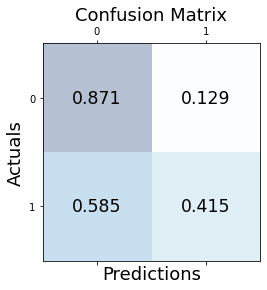

In [50]:
cm = np.round(sklearn.metrics.confusion_matrix(y_test, all_preds.max(axis=0), normalize="true"), 3)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(4,4))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# Better on positive preds, worse on negative preds, worse overall
### Let's try voting

In [65]:
acc = accuracy_score(y_test, np.round(all_preds.mean(axis=0)))
f1 = f1_score(y_test, np.round(all_preds.mean(axis=0)))
auc = roc_auc_score(y_test, np.round(all_preds.mean(axis=0)))
pos_preds = np.sum(np.round(all_preds.mean(axis=0)))
print(f"TEST ACCURACY FOR UNION OF ALL MODELS : {acc:.6f}; F1 : {f1:.6f}, ROC AUC {auc:.6f}, Positive Preds : {pos_preds}")

TEST ACCURACY FOR UNION OF ALL MODELS : 0.921250; F1 : 0.396937, ROC AUC 0.626991, Positive Preds : 367.0


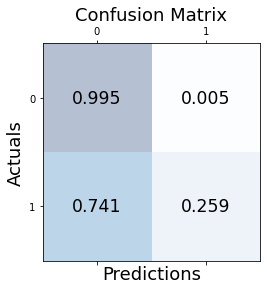

In [54]:
cm = np.round(sklearn.metrics.confusion_matrix(y_test, np.round(all_preds.mean(axis=0)), normalize="true"), 3)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(4,4))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# Try bumping up voting threshold

In [67]:
THRESHOLD_INCREASE: float = 0.4
acc = accuracy_score(y_test, np.round(all_preds.mean(axis=0)+THRESHOLD_INCREASE))
f1 = f1_score(y_test, np.round(all_preds.mean(axis=0)+THRESHOLD_INCREASE))
auc = roc_auc_score(y_test, np.round(all_preds.mean(axis=0)+THRESHOLD_INCREASE))
pos_preds = np.sum(np.round(all_preds.mean(axis=0)+THRESHOLD_INCREASE))
print(f"TEST ACCURACY FOR UNION OF ALL MODELS : {acc:.6f}; F1 : {f1:.6f}, ROC AUC {auc:.6f}, Positive Preds : {pos_preds}")

TEST ACCURACY FOR UNION OF ALL MODELS : 0.887500; F1 : 0.376155, ROC AUC 0.643796, Positive Preds : 964.0


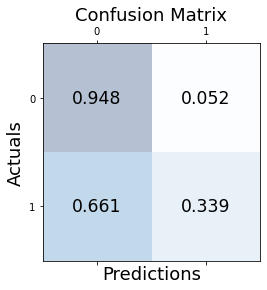

In [60]:
cm = np.round(sklearn.metrics.confusion_matrix(y_test, np.round(all_preds.mean(axis=0)+THRESHOLD_INCREASE), normalize="true"), 3)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(4,4))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# Does E4 with thresholding does as well as ensemble + thresholding?

In [85]:
THRESHOLD_INCREASE = 0.2
preds4_t = np.round(preds[4]+THRESHOLD_INCREASE).astype(np.int32)
acc = accuracy_score(y_test, preds4_t)
f1 = f1_score(y_test, preds4_t)
auc = roc_auc_score(y_test, preds4_t)
pos_preds = np.sum(preds4_t)
print(f"TEST ACCURACY FOR EPOCH 4 + THRESHOLD : {acc:.6f}; F1 : {f1:.6f}, ROC AUC {auc:.6f}, Positive Preds : {pos_preds}")

TEST ACCURACY FOR EPOCH 4 + THRESHOLD : 0.913667; F1 : 0.401848, ROC AUC 0.636481, Positive Preds : 532


# Answer: pretty much.  


# BUGFIX: ROC AUC score is calculated on the float prediction
### My roc_auc calculations above were on int predictions.  Let's see the float scores

In [109]:
epoch = 0
for preds_float in all_preds_float:
    epoch += 2
    auc = roc_auc_score(y_test, preds_float)
    print(f"EPOCH {epoch} ROC AUC : {auc}")

EPOCH 2 ROC AUC : 0.6956728395061729
EPOCH 4 ROC AUC : 0.6904094521604939
EPOCH 6 ROC AUC : 0.6639940972222222
EPOCH 8 ROC AUC : 0.6601858796296296
EPOCH 10 ROC AUC : 0.6562977623456789
EPOCH 12 ROC AUC : 0.6625400848765433
EPOCH 14 ROC AUC : 0.6578401234567901
EPOCH 16 ROC AUC : 0.6661332947530865
EPOCH 18 ROC AUC : 0.6778950617283952
EPOCH 20 ROC AUC : 0.6717935570987655


In [110]:
auc = roc_auc_score(y_test, all_preds_float.mean(axis=0))
print(f"MEAN ENSEMBLE ROC AUC : {auc}")

MEAN ENSEMBLE ROC AUC : 0.6971466820987654


In [111]:
auc = roc_auc_score(y_test, all_preds_float.max(axis=0))
print(f"MAX ENSEMBLE ROC AUC : {auc}")

MAX ENSEMBLE ROC AUC : 0.6971937114197531


In [115]:
THRESHOLD_INCREASE = 0.1
auc = roc_auc_score(y_test, np.clip(0,1,all_preds_float.mean(axis=0)+THRESHOLD_INCREASE))
print(f"MEAN ENSEMBLE ROC AUC : {auc}")

MEAN ENSEMBLE ROC AUC : 0.6971317901234568


In [118]:
test_labels: pd.DataFrame = pd.read_csv(os.path.join(datadir, "sample_submission.csv"), index_col=0)
def test_id_to_path(sample_id: str) -> str:
    """ Return full path to numpy file from sample id """
    return os.path.join(datadir, "test", sample_id[0], f"{sample_id}.npy")

# Not a huge difference between the different techniques

In [87]:
class TestDataGenerator(keras.utils.Sequence):
    def __init__(self, x_set, y_set=None, batch_size=32):
        self.x , self.y = x_set, y_set
        self.batch_size = batch_size
        self.is_train = False if y_set is None else True
        
    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)
    
    def __getitem__(self, idx):
        batch_ids = self.x[idx * self.batch_size: (idx + 1) * self.batch_size]
        if self.y is not None:
            batch_y = self.y[idx * self.batch_size: (idx + 1) * self.batch_size]
        
        list_x = [np.load(test_id_to_path(x))[::2] for x in batch_ids]
        batch_x = np.moveaxis(list_x,1,-1)
        batch_x = batch_x.astype("float") / 255
        
        if self.is_train:
            return batch_x, batch_y
        else:
            return batch_x

In [94]:
X_test_submission = test_labels['id'].values
test_submission_data = TestDataGenerator(X_test_submission, batch_size=batch_size)

In [95]:
model = keras.models.load_model(os.path.join("models", f"effnet_cadences_E4"))

In [96]:
preds_test_submission = model.predict(test_submission_data).flatten()

In [97]:
THRESHOLD_INCREASE = 0.2
preds4_t = np.round(preds_test_submission+THRESHOLD_INCREASE).astype(np.int32)

In [98]:
np.sum(preds4_t), len(preds4_t)

(4927, 39995)

In [119]:
test_labels["target"] = preds_test_submission

In [120]:
test_labels.head()

,target
id,
000bf832cae9ff1,0.068293
000c74cc71a1140,0.001906
000f5f9851161d3,0.100006
000f7499e95aba6,0.058308
00133ce6ec257f9,0.010594


In [121]:
test_labels.to_csv("submission.csv")